<a href="https://colab.research.google.com/github/michaelyoung1997/Development-of-AI-tools-to-link-climate-and-land-usage/blob/master/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Importing and formatting 

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

!pip install libtiff 
from libtiff import TIFF
import matplotlib.pyplot as plt

import ee 
ee.Authenticate()
ee.Initialize()

**Specify File Path**

In [ ]:
path='/content/drive/My Drive/Project/'

**Import Temperature Data** 

In [ ]:
filenames=['2001.xlsx', '2002.xlsx', '2003.xlsx', '2004.xlsx', '2005.xlsx', '2006.xlsx', '2007.xlsx', '2008.xlsx', '2009.xlsx', '2010.xlsx']
stations = pd.read_excel(path+'stations.xlsx', header=None, index_col=0)
stations
def resize_data(filename):
    temp=pd.read_excel(str(path+'Average Temps/'+filename), index_col=5, header=None)
    temp=temp.drop(temp.index[0])
    temp=temp.drop(temp.columns[list(range(5))], axis=1).transpose()
    temp.index=stations.index
    return temp


dataframe=stations
year=2001
months=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for filename in filenames:
    yearframe=resize_data(filename)
    # yearframe.columns=pd.MultiIndex.from_tuples([tuple([month, year]) for month in yearframe.columns])
    # yearframe.columns=[str(month)+'_'+str(year) for month in yearframe.columns]
    yearframe.columns=[str(year)+'-'+str(month) for month in months]

    dataframe=pd.concat([dataframe, yearframe], axis=1)
    year+=1
    
dataframe.rename(columns={1:'Easting', 2:'Northing'}, inplace=True)
dataframe.index.name='Stations'
dataframe=(dataframe.replace(r'^\s*$', np.nan, regex=True)) 
dataframe

,Easting,Northing,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,...,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12
Stations,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,462488,1207786,5.027554,2.183333,3.341857,5.599305,8.808378,9.594437,12.058602,12.510498,10.629248,11.394231,5.806713,4.146964,5.192605,4.020982,4.785868,7.377222,9.196909,12.476111,12.598385,14.008254,12.174722,7.712231,6.767278,5.324866,4.637787,5.161458,6.876747,7.248333,8.811425,11.970376,14.518280,14.000134,11.460918,7.455331,7.577191,4.896505,4.054435,4.541810,...,10.053889,9.909673,6.081111,6.000134,4.054435,4.541810,6.145541,7.751389,8.576882,10.801543,12.304032,13.527995,11.603056,9.297222,6.377361,5.972849,5.350403,4.056399,5.958277,8.305000,9.721505,11.114444,13.396171,13.115374,11.752156,8.448253,7.448333,4.151478,2.997715,1.611458,5.068329,5.760508,7.333468,10.669028,12.565860,12.511559,10.772524,8.421774,4.200000,2.030108
9,445392,1139664,4.579301,2.094792,2.965054,5.104444,8.136156,8.982222,11.383199,11.946640,10.085139,10.397581,5.718333,4.049328,5.321237,3.488823,4.338575,6.529583,8.604973,11.737361,12.032930,13.481989,11.777778,7.326344,6.612917,4.988575,4.247849,4.595536,6.396909,6.726528,8.156586,11.407083,14.010081,13.473253,11.219306,7.232392,7.469028,4.818145,3.998387,4.002158,...,9.523611,9.208871,5.583333,5.411425,3.998387,4.002158,5.546102,7.041168,9.020961,NaN,11.591667,13.297849,11.123750,8.808056,6.057917,5.646371,4.800269,3.481250,5.259005,7.390972,8.910215,10.665833,13.170296,12.854435,11.406111,8.343548,7.309444,4.016801,2.706048,1.646875,4.696640,5.853611,7.008468,10.213333,12.149597,11.994355,10.610833,8.232258,3.939444,1.538844
10,439783,1173826,4.986810,2.627844,3.500837,5.685278,8.636559,9.543394,11.962803,12.661911,10.721806,11.113594,6.511667,4.498656,5.744086,4.244940,4.919015,7.190300,9.343929,12.569444,12.617876,14.212634,12.390972,8.097312,6.932222,5.341263,4.874462,5.179464,6.709152,7.677019,8.956586,12.342361,14.877419,14.325034,11.804336,7.955855,7.970000,5.460296,4.674597,4.924282,...,NaN,NaN,NaN,NaN,4.674597,4.924282,6.152660,NaN,NaN,10.724348,12.260653,13.854987,12.841369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,440300,1188800,6.018207,3.835726,4.200909,6.013130,8.691622,10.938554,11.591176,12.220135,10.651253,10.970340,7.085574,5.839349,6.337703,4.824962,4.708174,4.795781,0.268471,6.002941,10.286505,13.167794,11.891632,8.211351,7.254622,5.712060,5.419350,5.333635,6.615156,6.854979,8.032285,10.965963,13.124932,13.077341,11.216835,7.783106,7.966152,5.849252,4.924218,5.140439,...,NaN,NaN,NaN,NaN,4.924218,5.140439,6.550000,NaN,9.091603,12.895474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,421046,1071185,5.608873,3.443299,4.112702,5.873902,8.414079,9.587469,11.772170,12.542093,10.890465,11.162704,7.007386,5.413366,6.587013,4.776823,5.415496,7.126142,9.302619,11.947044,12.687617,13.737647,12.440360,8.668882,7.801832,6.054591,5.434414,5.571543,6.997356,7.582697,8.887032,11.849505,14.098568,14.024207,12.183854,8.685507,8.806250,6.144750,5.270813,5.326913,...,10.146842,9.945250,6.961598,6.405836,5.270813,5.326913,6.367303,7.751345,10.712158,10.596825,12.180145,13.597354,11.880741,9.711145,7.202638,6.793882,5.677494,4.418028,6.005115,7.659367,9.298214,11.081818,13.382322,13.257592,12.097319,9.540979,8.264191,5.427704,

**Generate 2007 Land Cover Dataframe**


In [ ]:
def gaussian_blur(im, n, e):
  N=-1-n 
  return (4*im[N,e]+2*(im[N+1, e]+im[N,e+1]+im[N-1, e]+im[N, e-1])+im[N-1, e-1]+im[N-1, e+1]+im[N+1, e-1]+im[N+1, e+1])/16


In [ ]:
def get_values7(im, dataframe):
  Easting=dataframe['Easting']
  Northing=dataframe['Northing']
  lci=[]
  gim=gaussian_filter(im, sigma=3.5)
  for row in dataframe.index:
    e=int(round((Easting[row]/1000))-1)
    n=int(round((Northing[row]/1000))-1)

    if e>im.shape[1] or n>im.shape[0]:
      lci.append(-1000)
    else: 
      #For some reason, LC2007 map is flippped upside down 

      lci.append(im[-1-n,e])
      # lci.append(gaussian_blur(im, n, e))

  return lci

In [ ]:

land_cover07=dataframe[['Easting', 'Northing']]
lc07=[] 
class_list07=['1.tif', '2.tif', '3.tif', '4.tif', '5.tif', '6.tif', '7.tif', '8.tif', '9.tif', '10.tif']

for classes in class_list07: 
  raster_grid = TIFF.open(str(path+'Land Cover 1km/lcm-2007-1km_3525792/percentage_aggregate_class/LCM2007_GB_1K_PC_AggregateClass_'+classes)).read_image()   


  lc07.append(np.array(get_values7(raster_grid, land_cover07)))


for i in range(len(lc07)): 
  land_cover07[i]=lc07[i] 
    

land_cover07.rename(columns={0: 'Broadleaf woodland', 1:'Coniferous woodland', 2:'Arable ', 3:'Improved Grassland', 4:'Semi-natural grassland', 5:'Mountain Heath', 6:'Saltwater', 7:'Freshwater', 8:'Coastal', 9:'Built-up/gardens'}, inplace=True)
col_list= list(land_cover07)
col_list.remove('Easting')
col_list.remove('Northing')
land_cover07['Sum']=land_cover07[col_list].sum(axis=1)
land_cover07['Land']=sum([land_cover07['Sum']>0] )

#dataframe is upside down 
# land_cover07['Northing']=1300000-land_cover07['Northing']

land_cover07




     |████████████████████████████████| 133kB 2.8MB/s 
  Created wheel for libtiff: filename=libtiff-0.4.2-cp36-cp36m-linux_x86_64.whl size=280175 sha256=9d8f9bfba3d28c40e79c79aadb6de3ed0697492061e43c53fec9c3685c5e6b27
  Stored in directory: /root/.cache/pip/wheels/7c/ce/79/9c7115224f798f73bdbd2c23e06c6fa048adcca7041b9fd104
Successfully built libtiff


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

,Easting,Northing,Broadleaf woodland,Coniferous woodland,Arable,Improved Grassland,Semi-natural grassland,Mountain Heath,Saltwater,Freshwater,Coastal,Built-up/gardens,Sum,Land
Stations,,,,,,,,,,,,,,
12,462488,1207786,0,0,0,0,23,77,0,0,0,0,100,1
9,445392,1139664,0,0,4,8,44,36,0,7,0,1,100,1
10,439783,1173826,0,0,0,0,3,28,5,1,5,5,47,1
11,440300,1188800,0,0,0,0,0,0,0,0,0,0,0,0
3,421046,1071185,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13343,209600,542600,20,11,13,41,14,0,0,1,0,0,100,1
30273,336300,162800,0,0,0,9,0,0,0,0,0,90,99,1
30137,225516,911619,3,28,0,3,27,26,0,13,0,0,100,1


**Generate complete raster of UK**

In [ ]:
lc07=[] 
class_list07=['1.tif', '2.tif', '3.tif', '4.tif', '5.tif', '6.tif', '7.tif', '8.tif', '9.tif', '10.tif']
total=np.zeros([1300,700])
for classes in class_list07: 
  raster_grid = TIFF.open(str(path+'Land Cover 1km/lcm-2007-1km_3525792/percentage_aggregate_class/LCM2007_GB_1K_PC_AggregateClass_'+classes)).read_image()   
  total=total+raster_grid

np.unique(total)  




array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103.])

In [ ]:
total=np.loadtxt(path+'total_landcover')

**Plot 2007 stations over UK raster**

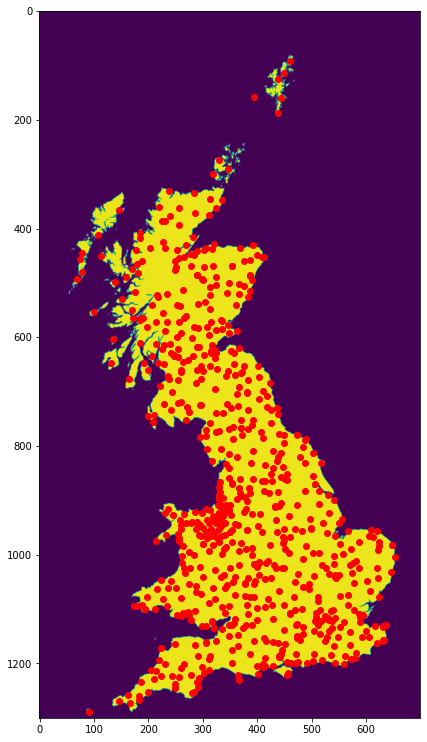

In [ ]:
plt.figure(figsize=(7,13))
plt.imshow(total)

land=land_cover07['Land']>0
water=land_cover07['Land']==0

# plt.scatter([10, 700], [10, 1300])
plt.scatter(round(land_cover07[land]['Easting']/1000)-1, 1300-round(land_cover07[land]['Northing']/1000)-1, c='red', label='Land')
# # plt.title(['2007 Dataset'])
plt.ylim([1300,0])
# plt.legend(fontsize=14)
plt.show() 




**Generate 2015 Land Cover Dataframe**

In [ ]:


raster_2015=TIFF.open(path+'Land Cover 1km/LCM2015_GB_1km_percent_cover_aggregate_class.tif').read_image() 

raster_2015.shape



land_cover15=dataframe[['Easting', 'Northing']]
lc15=[] 

for i in range(raster_2015.shape[2]): 
  raster_grid = raster_2015[:,:,i]
  lc15.append(np.array(get_values7(raster_grid, land_cover15)))


for i in range(len(lc15)): 
  land_cover15[i]=lc15[i] 
    

land_cover15.rename(columns={0: 'Broadleaf woodland', 1:'Coniferous woodland', 2:'Arable ', 3:'Improved Grassland', 4:'Semi-natural grassland', 5:'Mountain Heath', 6:'Saltwater', 7:'Freshwater', 8:'Coastal', 9:'Built-up/gardens'}, inplace=True)
col_list= list(land_cover15)
col_list.remove('Easting')
col_list.remove('Northing')
land_cover15['Sum']=land_cover15[col_list].sum(axis=1)
land_cover15['Land']=sum([land_cover15['Sum']>0] )

#dataframe is upside down 
# land_cover07['Northing']=1300000-land_cover07['Northing']

land_cover15


     |████████████████████████████████| 133kB 4.8MB/s 
  Created wheel for libtiff: filename=libtiff-0.4.2-cp36-cp36m-linux_x86_64.whl size=280191 sha256=50dd47a6b72be0f008fd4cf18ce40f5c361582ff9f6ccd5ffe54b1af47dbd097
  Stored in directory: /root/.cache/pip/wheels/7c/ce/79/9c7115224f798f73bdbd2c23e06c6fa048adcca7041b9fd104
Successfully built libtiff


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,Easting,Northing,Broadleaf woodland,Coniferous woodland,Arable,Improved Grassland,Semi-natural grassland,Mountain Heath,Saltwater,Freshwater,Coastal,Built-up/gardens,Sum,Land
Stations,,,,,,,,,,,,,,
12,462488,1207786,0.0000,0.0000,0.0000,18.8750,3.000,43.1250,0.0000,0.1250,0.6250,1.0000,66.7500,1
9,445392,1139664,0.0000,0.0000,0.0000,22.3750,0.000,28.5000,0.0000,6.1250,1.1250,3.4375,61.5625,1
10,439783,1173826,0.0000,0.0000,0.0000,11.5625,0.000,30.4375,45.7500,0.0000,5.6875,6.3750,99.8125,1
11,440300,1188800,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0625,0.0000,1.2500,0.0000,1.3125,1
3,421046,1071185,0.0000,0.0000,0.0000,30.9375,4.750,12.8125,0.0000,0.0000,4.2500,0.0625,52.8125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13343,209600,542600,18.1875,0.5000,15.8125,57.2500,0.000,0.0000,1.5625,0.6875,0.1875,1.3750,95.5625,1
30273,336300,162800,1.9375,0.0000,0.5000,16.0625,0.000,0.0000,0.0000,0.2500,0.0000,49.4375,68.1875,1
30137,225516,911619,1.4375,28.5000,0.0000,7.8125,11.625,42.3750,0.0000,8.5625,0.0000,0.0000,100.3125,1


In [ ]:
plt.figure(figsize=(7,13))
plt.imshow(total)

land=land_cover15['Land']>0
water=land_cover15['Land']==0

# plt.scatter([10, 700], [10, 1300])
plt.scatter(round(land_cover15[land]['Easting']/1000)-1, 1300-round(land_cover15[land]['Northing']/1000)-1, c='red')
plt.scatter(round(land_cover15[water]['Easting']/1000)-1, 1300-round(land_cover15[water]['Northing']/1000)-1, c='blue')
# # plt.title(['2007 Dataset'])
plt.ylim([1300,0])

plt.show() 

NameError: ignored

<Figure size 504x936 with 0 Axes>

**Convert station BNG coordinates to ESPG:4326 (global)**

In [ ]:

# !pip install pyproj 
from pyproj import Transformer 
transformer = Transformer.from_crs("epsg:27700", "epsg:4326")

#transformer.transform([eastingarray], [northingarray])
global_points=(np.array(transformer.transform(list(land_cover07['Easting'][land]), list(land_cover07['Northing'][land]))).T)


#flip X and Y of transformed coordinates 

global_points=np.flip(global_points,1) 

global_points=global_points.tolist() 
len(global_points)



710

**Generate list of station altitudes**

In [ ]:
height_list=[] 

dem = ee.Image('USGS/SRTMGL1_003')
points=[[86.9250, 27.9881], [87, 30]]
for pointed in global_points: 
  xy = ee.Geometry.Point(pointed)
  try:
    height_list.append(dem.sample(xy, 30).first().get('elevation').getInfo())
  except:
    height_list.append(-9999 )

# height_list=np.loadtxt(path+'height_list')

#After correction
# height_list=np.loadtxt(path+'height_list2')

#gaussian_blurred 3x3
# height_list=np.loadtxt(path+'height_listgb')

#gaussian_blurred 5x5
# height_list=np.loadtxt(path+'height_listgb5')


**Generate mask of onshore stations (based on availability from GEE)**

In [ ]:
true_vals=[] 
for height in height_list:
  if height!=-9999:
    true_vals.append(True)
  else:
    true_vals.append(False)

**Update land cover dataframe**

In [ ]:
land_cover07=land_cover07[land]
land_cover07['Altitude']=height_list
land_cover07=land_cover07[true_vals]
land_cover07=land_cover07.drop(['Sum', 'Land'], axis=1)

land_cover07

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Easting,Northing,Broadleaf woodland,Coniferous woodland,Arable,Improved Grassland,Semi-natural grassland,Mountain Heath,Saltwater,Freshwater,Coastal,Built-up/gardens,Altitude
Stations,,,,,,,,,,,,,
23,348236,1007709,0.0000,0.1250,2.9375,28.4375,37.0000,24.8750,1.7500,0.2500,0.0000,2.1250,27.0
18903,76312,842502,0.0000,0.0000,0.0000,2.4375,10.7500,0.5000,0.0000,8.5000,53.1875,0.0000,3.0
54,146443,933104,0.0000,0.1250,1.8750,20.4375,47.0000,10.1875,0.1875,0.3125,3.8750,7.8125,14.0
67,227669,874255,37.6875,0.7500,0.0000,0.0000,6.9375,51.0000,0.0000,3.4375,0.0000,0.0000,267.0
52,184575,891274,1.1250,0.6250,0.0000,8.8125,4.0625,17.4375,0.6250,0.3750,3.7500,0.1250,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13343,209600,542600,14.8750,5.9375,16.1250,47.0000,8.4375,0.0000,0.3750,1.8750,0.4375,0.8125,31.0
30273,336300,162800,2.0625,0.2500,9.8750,12.3125,1.3750,0.0000,0.0000,0.2500,0.0000,73.6875,6.0
30137,225516,911619,1.6250,28.5000,0.0000,3.6875,19.3750,38.1875,0.0000,8.6250,0.0000,0.0000,148.0


In [ ]:
land_cover15=land_cover15.loc[land_cover07.index]
land_cover15['Altitude']=height_list[true_vals]

land_cover15=land_cover15.drop(['Sum', 'Land'], axis=1)

land_cover15

KeyError: ignored

**Export** 

In [ ]:
# land_cover07.to_csv(path+'landuse_07.csv')
dataframe.to_csv(path+'monthly_averages.csv')
# land_cover15.to_csv(path+'landuse_2015gb.csv')

**Get population density**

In [ ]:
population_density=[] 

pop_map = ee.Image("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density")

for pointed in global_points: 
  xy = ee.Geometry.Point(pointed)
  try:
    population_density.append(pop_map.sample(xy, 30).first().get('elevation').getInfo())
  except:
    population_density.append(-9999 )

**Calculate euclidean distance from coast**



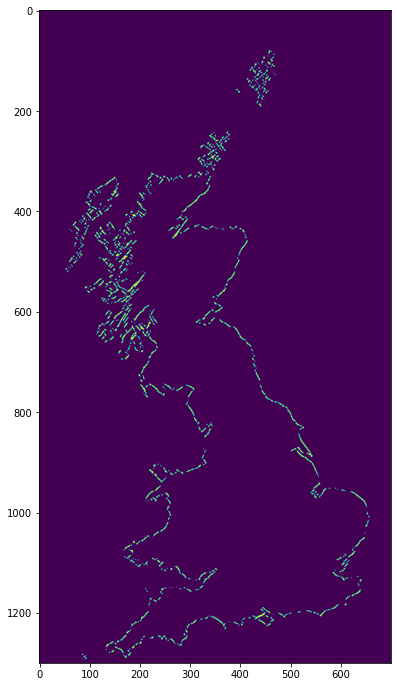

In [ ]:
import cv2 
plt.figure(figsize=(8,12))

gb=cv2.GaussianBlur(total,(3,3),0)
im=cv2.Sobel(gb,cv2.CV_64F,1,1,ksize=5) #+ cv2.Sobel(gb,cv2.CV_64F,1,0,ksize=5)
plt.imshow(im>200, cmap='gray')


y,x=np.where(im>200)
y=np.subtract(1300, y)

y.shape
coastlines=[]
for i in range(len(x)):
  coastlines.append(tuple([x[i], y[i]]))



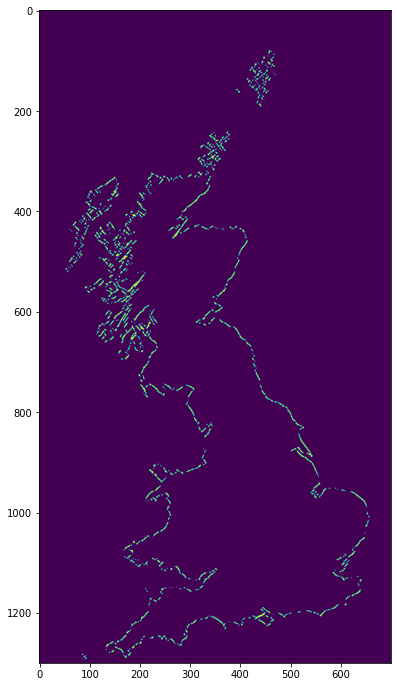

In [ ]:
import cv2 
plt.figure(figsize=(8,12))

gb=cv2.GaussianBlur(total,(3,3),0)
plt.imshow(im>200)

In [ ]:
easting=list(land_cover07['Easting']/1000)
northing=list(land_cover07['Northing']/1000)

station_coords=[]
for i in range(len(easting)):
  station_coords.append(tuple([easting[i], northing[i]]))


In [ ]:
station=station_coords[0]

def euclidean_dist(c):
  return np.sqrt((c[0]-station[0])**2 + (c[1]-station[1])**2) 
inland=[]
for station in station_coords: 
  inland.append(min(map(euclidean_dist, coastlines)))

In [ ]:
inland=pd.Series(inland, index=land_cover07.index, name='Inland')
inland.to_csv(path+'inland.csv')